## K 최근접 이웃 알고리즘 (K-Nearest Neighbor)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Uniform distribution을 이용해서 10 * 2 배열을 임의로 생성한다.
random_generator = np.random.RandomState(42)
dataset = random_generator.rand(10, 2)
dataset

array([[0.37454012, 0.95071431],
       [0.73199394, 0.59865848],
       [0.15601864, 0.15599452],
       [0.05808361, 0.86617615],
       [0.60111501, 0.70807258],
       [0.02058449, 0.96990985],
       [0.83244264, 0.21233911],
       [0.18182497, 0.18340451],
       [0.30424224, 0.52475643],
       [0.43194502, 0.29122914]])

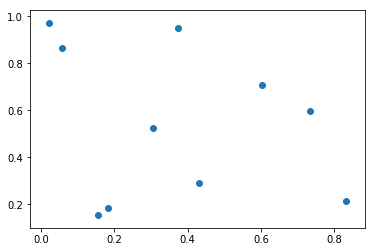

In [3]:
# Plot (아주 간단하게 plot)
x = dataset[:, 0]
y = dataset[:, 1]
plt.scatter(x, y)

두 점 $v_1 = (x_1, y_1), v_2 = (x_2, y_2)$가 주어졌을 때, 두 점 사이의 거리 $\text{dist}(v_1, v_2)=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}$이다.

dataset은 $\{v_1, v_2, ..., v_10\}$이고, 가까운 데이터와의 거리를 재기 위해서,
 - $v_1$에 대하여, $\text{dist}(v_1, v_2), \text{dist}(v_1, v_3), ..., \text{dist}(v_1, v_{10})$
 - $v_2$에 대하여, $\text{dist}(v_2, v_1), \text{dist}(v_2, v_3), ..., \text{dist}(v_2, v_{10})$
 - $v_{10}$에 대하여, $\text{dist}(v_{10}, v_1), \text{dist}(v_{10}, v_2), ..., \text{dist}(v_{10}, v_1)$
 
를 각각 구해야 한다.

이를 계산하기 위해서 broadcasting 기능을 활용한다.

## 1. Step by step

### 1.1. Vector간의 difference

In [4]:
# dataset[: np.newaxis, :] 도 사용가능
row = dataset.reshape(10, 1, 2)
row

array([[[0.37454012, 0.95071431]],

       [[0.73199394, 0.59865848]],

       [[0.15601864, 0.15599452]],

       [[0.05808361, 0.86617615]],

       [[0.60111501, 0.70807258]],

       [[0.02058449, 0.96990985]],

       [[0.83244264, 0.21233911]],

       [[0.18182497, 0.18340451]],

       [[0.30424224, 0.52475643]],

       [[0.43194502, 0.29122914]]])

In [5]:
# dataset[np.newaxis, :, :] 도 사용가능
other_rows = dataset.reshape(1, 10, 2)
other_rows

array([[[0.37454012, 0.95071431],
        [0.73199394, 0.59865848],
        [0.15601864, 0.15599452],
        [0.05808361, 0.86617615],
        [0.60111501, 0.70807258],
        [0.02058449, 0.96990985],
        [0.83244264, 0.21233911],
        [0.18182497, 0.18340451],
        [0.30424224, 0.52475643],
        [0.43194502, 0.29122914]]])

In [6]:
print('Shape1', row.shape)
print('Shape2', other_rows.shape)

Shape1 (10, 1, 2)
Shape2 (1, 10, 2)


In [7]:
differences = row - other_rows
differences

array([[[ 0.        ,  0.        ],
        [-0.35745382,  0.35205582],
        [ 0.21852148,  0.79471979],
        [ 0.31645651,  0.08453816],
        [-0.22657489,  0.24264173],
        [ 0.35395562, -0.01919555],
        [-0.45790252,  0.7383752 ],
        [ 0.19271515,  0.7673098 ],
        [ 0.07029788,  0.42595787],
        [-0.0574049 ,  0.65948517]],

       [[ 0.35745382, -0.35205582],
        [ 0.        ,  0.        ],
        [ 0.5759753 ,  0.44266396],
        [ 0.67391033, -0.26751766],
        [ 0.13087893, -0.10941409],
        [ 0.71140945, -0.37125137],
        [-0.1004487 ,  0.38631937],
        [ 0.55016897,  0.41525397],
        [ 0.4277517 ,  0.07390205],
        [ 0.30004892,  0.30742934]],

       [[-0.21852148, -0.79471979],
        [-0.5759753 , -0.44266396],
        [ 0.        ,  0.        ],
        [ 0.09793503, -0.71018163],
        [-0.44509637, -0.55207806],
        [ 0.13543415, -0.81391533],
        [-0.676424  , -0.05634459],
        [-0.02580633, -0

In [8]:
differences.shape

(10, 10, 2)

### 1.2. Differences의 제곱

In [9]:
sq_differences = differences ** 2

In [10]:
sq_differences

array([[[0.00000000e+00, 0.00000000e+00],
        [1.27773236e-01, 1.23943302e-01],
        [4.77516365e-02, 6.31579538e-01],
        [1.00144721e-01, 7.14670060e-03],
        [5.13361821e-02, 5.88750085e-02],
        [1.25284584e-01, 3.68468977e-04],
        [2.09674720e-01, 5.45197930e-01],
        [3.71391297e-02, 5.88764324e-01],
        [4.94179135e-03, 1.81440111e-01],
        [3.29532252e-03, 4.34920684e-01]],

       [[1.27773236e-01, 1.23943302e-01],
        [0.00000000e+00, 0.00000000e+00],
        [3.31747548e-01, 1.95951385e-01],
        [4.54155132e-01, 7.15656993e-02],
        [1.71292943e-02, 1.19714439e-02],
        [5.06103402e-01, 1.37827578e-01],
        [1.00899411e-02, 1.49242658e-01],
        [3.02685901e-01, 1.72435863e-01],
        [1.82971516e-01, 5.46151337e-03],
        [9.00293563e-02, 9.45128016e-02]],

       [[4.77516365e-02, 6.31579538e-01],
        [3.31747548e-01, 1.95951385e-01],
        [0.00000000e+00, 0.00000000e+00],
        [9.59126976e-03, 5.043

### 1.3. 제곱간의 합 

In [11]:
sq_differences = sq_differences.sum(-1)
sq_differences

array([[0.        , 0.25171654, 0.67933117, 0.10729142, 0.11021119,
        0.12565305, 0.75487265, 0.62590345, 0.1863819 , 0.43821601],
       [0.25171654, 0.        , 0.52769893, 0.52572083, 0.02910074,
        0.64393098, 0.1593326 , 0.47512176, 0.18843303, 0.18454216],
       [0.67933117, 0.52769893, 0.        , 0.51394921, 0.50290096,
        0.68080058, 0.46072414, 0.00141727, 0.15795558, 0.09442377],
       [0.10729142, 0.52572083, 0.51394921, 0.        , 0.31987984,
        0.01216687, 1.02713477, 0.48148903, 0.17716149, 0.47033641],
       [0.11021119, 0.02910074, 0.50290096, 0.31987984, 0.        ,
        0.40557444, 0.29926414, 0.45108072, 0.12173825, 0.20237694],
       [0.12565305, 0.64393098, 0.68080058, 0.01216687, 0.40557444,
        0.        , 1.23302708, 0.64458914, 0.27862329, 0.62982499],
       [0.75487265, 0.1593326 , 0.46072414, 1.02713477, 0.29926414,
        1.23302708, 0.        , 0.42414057, 0.37660024, 0.16662198],
       [0.62590345, 0.47512176, 0.0014172

### 1.4. Root

In [12]:
distances = np.sqrt(sq_differences)
distances

array([[0.        , 0.5017136 , 0.82421549, 0.32755369, 0.33198071,
        0.35447574, 0.86883407, 0.7911406 , 0.4317197 , 0.66197886],
       [0.5017136 , 0.        , 0.72642889, 0.72506609, 0.17058938,
        0.8024531 , 0.39916488, 0.68929077, 0.43408873, 0.4295837 ],
       [0.82421549, 0.72642889, 0.        , 0.71690251, 0.7091551 ,
        0.8251064 , 0.67876663, 0.0376467 , 0.39743626, 0.30728451],
       [0.32755369, 0.72506609, 0.71690251, 0.        , 0.56557921,
        0.11030352, 1.01347658, 0.69389411, 0.42090556, 0.68581077],
       [0.33198071, 0.17058938, 0.7091551 , 0.56557921, 0.        ,
        0.63684727, 0.5470504 , 0.67162543, 0.34891009, 0.44986324],
       [0.35447574, 0.8024531 , 0.8251064 , 0.11030352, 0.63684727,
        0.        , 1.11041752, 0.80286309, 0.52784779, 0.79361514],
       [0.86883407, 0.39916488, 0.67876663, 1.01347658, 0.5470504 ,
        1.11041752, 0.        , 0.65126075, 0.61367764, 0.40819356],
       [0.7911406 , 0.68929077, 0.0376467

In [13]:
nearest = np.argsort(distances, axis=1)
nearest

array([[0, 3, 4, 5, 8, 1, 9, 7, 2, 6],
       [1, 4, 6, 9, 8, 0, 7, 3, 2, 5],
       [2, 7, 9, 8, 6, 4, 3, 1, 0, 5],
       [3, 5, 0, 8, 4, 9, 7, 2, 1, 6],
       [4, 1, 0, 8, 9, 6, 3, 5, 7, 2],
       [5, 3, 0, 8, 4, 9, 1, 7, 2, 6],
       [6, 1, 9, 4, 8, 7, 2, 0, 3, 5],
       [7, 2, 9, 8, 6, 4, 1, 3, 0, 5],
       [8, 9, 4, 7, 2, 3, 0, 1, 5, 6],
       [9, 8, 7, 2, 6, 1, 4, 0, 3, 5]])

첫번째 결과인 `[0, 3, 4, 5, 8, 1, 9, 7, 2, 6]`을 해석해보면, 첫 번째로 작은 값을 가진 entry의 index는 0, 두 번째로 작은 값을 가진 entry의 index는 3, 그 다음으로는 index가 4 이다.

0번 column은 row index에 해당하는 값이고(자기 자신과의 거리는 0이므로), 첫 번째 column이 가장 가까운 점이다.

$k$ 번째라면 각 행을 partition으로 나눠 가장 작은 $k+1$개의 거리가 먼저 오고, 그 보다 큰 거리의 요소를 배열의 나머지 위치에 채우면 된다.

### 1.5. $k$개 이웃 선정

In [14]:
# k = 2라고 하자.
k = 2
knn = nearest[:, 1:k+1]
knn

array([[3, 4],
       [4, 6],
       [7, 9],
       [5, 0],
       [1, 0],
       [3, 0],
       [1, 9],
       [2, 9],
       [9, 4],
       [8, 7]])

### 1.6. Plot

- $v_1$과 가장 가까운 데이터는 $v_4$, $v_5$

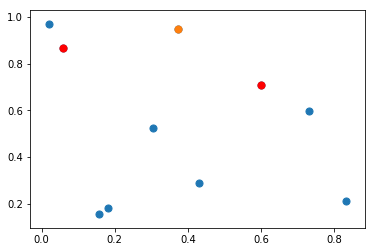

In [15]:
plt.scatter(x, y, s=50)
plt.scatter(dataset[0][0], dataset[0][1], s=50) # v1
nearest = dataset[knn[0]] # v4, v5
plt.scatter(nearest[:, 0], nearest[:, 1], c='r', s=50)

$v_{10}$과 가장 가까운 데이터는 $v_8$, $v_7$

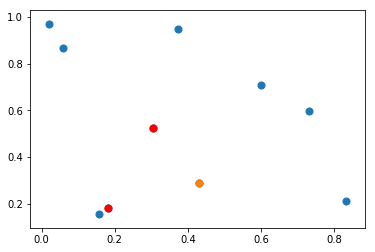

In [16]:
plt.scatter(x, y, s=50)
plt.scatter(dataset[9][0], dataset[9][1], s=50) # v9
nearest = dataset[knn[9]] # v8, v7
plt.scatter(nearest[:, 0], nearest[:, 1], c='r', s=50)

## 2. 함수로 정의

In [17]:
def knn(dataset, k):
    dist = np.sqrt(np.sum((dataset[:, np.newaxis, :] - dataset[np.newaxis, :, :]) ** 2, axis=-1))
    near = np.argpartition(dist, k+1, axis=1)
    
    return near[:, :k+1]

In [18]:
knn(dataset, 2)

array([[3, 0, 4],
       [1, 4, 6],
       [2, 7, 9],
       [3, 5, 0],
       [1, 4, 0],
       [5, 3, 0],
       [1, 9, 6],
       [7, 2, 9],
       [8, 9, 4],
       [8, 7, 9]])

다만, `argpartition` method는 정렬 후, 작은 순서로 $k+1$인 숫자를 맨 좌측 partition에 배치하되, 배치 한 후에는 그 partition 내부에서의 order는 보장하지 않는다.